# Master Thesis Project
### Evaluation of Machine Learning for Asset Management

"Insert Abstract"

### 0. Import Packages

First lets import all functions and classes from we will need for our project. For a detailed description of the packages refer to the requirements file.

In [1]:
from data_engineering import *
from denoising_and_detoning import *
from algorithm import *
from portfolio_and_backtesting import *

### 1. Data Preparation and Exploration

In this part we will dowload the data and visualized some of the underlying features.

##### 1.1 Loading Data

We will utilize the returns of the 503 S&P500 component stocks. The data ranges throughout the period of the past 5 years, starting in November. 

In [62]:
tickers = getTickers()
end = dt.fromisoformat('2022-11-17')
start = dt.fromisoformat('2012-11-17')
df = getData(start, end, tickers, downloaded = True)

Download in running....
Data was downloaded sucessfully!


The input data is structured as follows. For 11 stocks we couldnt locate all data so for the purpose of this project we will these smaller component stocks.

In [63]:
df.head()

Symbols,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACGL,ACN,ADBE,...,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2012-11-20,-0.032791,0.034797,-0.001800,-0.008520,0.002703,-0.014194,0.002543,0.003011,-0.006412,-0.008505,...,0.010778,0.010209,-0.001148,-0.001939,-0.005137,0.011272,-0.012684,0.007293,0.006884,0.016235
2012-11-21,-0.012128,-0.001601,0.003606,0.001408,0.001225,0.005760,0.003963,0.011778,0.013958,0.006127,...,0.001142,0.010854,0.000766,0.005829,0.001807,0.008758,0.015748,-0.004072,0.008151,0.007489
2012-11-23,0.029018,0.002406,0.014244,0.017447,0.012974,0.020043,0.018001,0.005935,0.009177,0.017052,...,0.016356,0.012034,-0.004210,0.012271,0.012887,0.007103,0.006392,0.012267,0.018779,0.023786
2012-11-26,0.015998,0.033600,-0.011134,0.031549,0.001692,0.004211,-0.001706,0.007715,-0.007480,-0.003293,...,-0.005988,-0.016098,0.011145,-0.005275,-0.002036,0.013323,-0.005000,-0.010323,-0.004352,0.002420
2012-11-27,-0.003469,-0.015480,-0.019831,-0.008057,-0.005549,0.023760,-0.004661,-0.004278,-0.004729,-0.003304,...,0.000000,0.006414,0.005321,-0.014331,-0.008924,-0.008894,0.002309,-0.001965,-0.005143,-0.036214


##### 1.2 Data Visualization

A chart the shows the percentage returns over the period of the sample. We observe daily returns are concentrated around the mean of 0. Although most returns do not exceed the absolute 20% mark the dataset features a few outliers that hit returns beyond 70%.

Text(0.5, 1.0, 'Daily returns of S&P500 Stocks for Training Period')

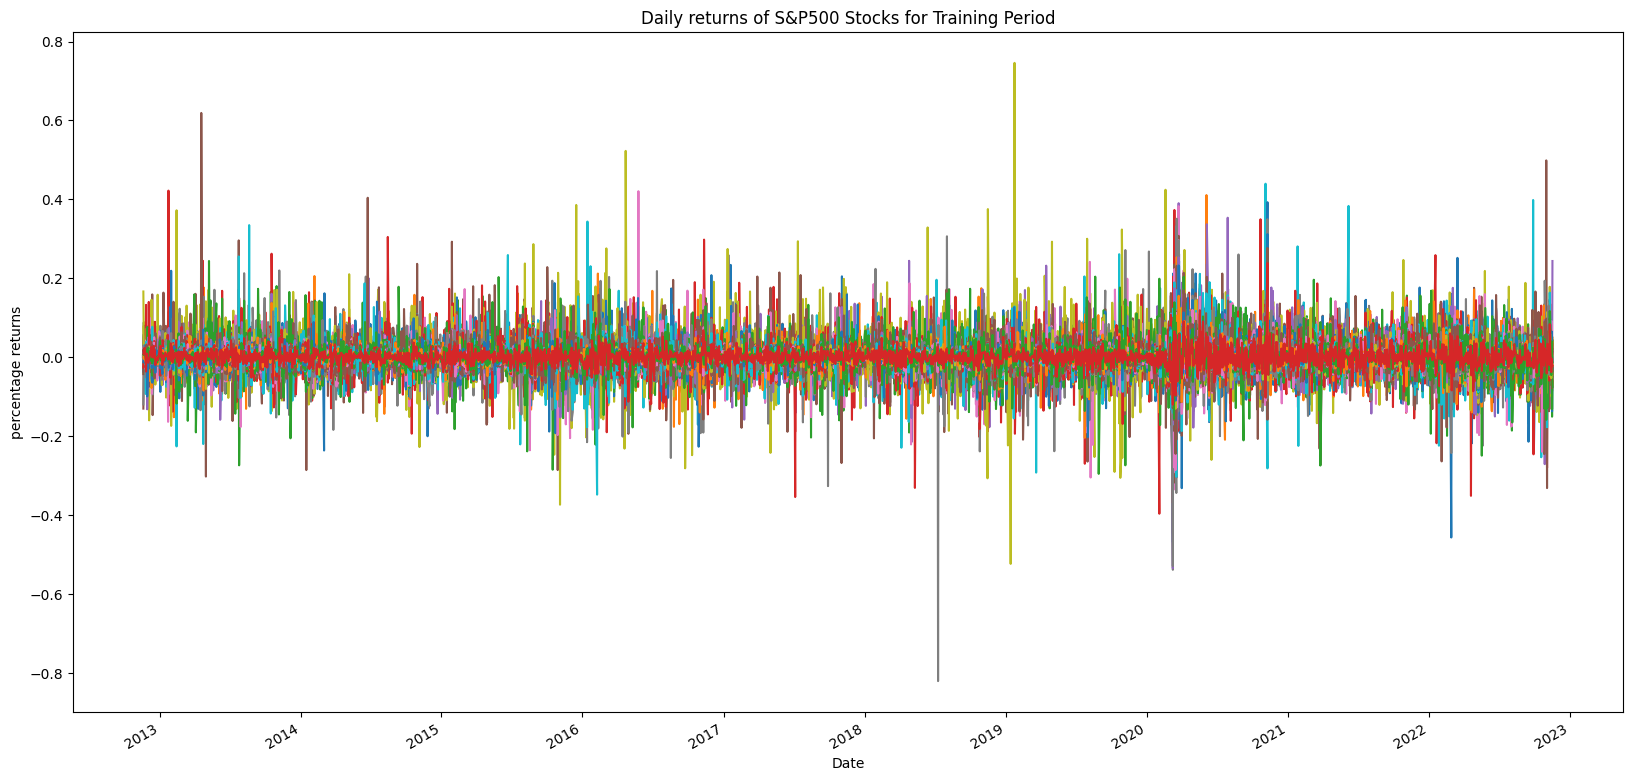

In [64]:
ax = df.plot(legend=False, figsize=(20,10))
ax.set_ylabel('percentage returns')
ax.set_title('Daily returns of S&P500 Stocks for Training Period')

To grasp a first idea of the data we are facing we plot the cummulative returns of the underlying S&P500 index over our sample period. Throughout the past 10 years we detect a mostly positive movement. Nevertheless, the recent market trends are rather negative, mostly drive by economic instability centered around the main topic of inflation. Moreover, we can observe the negative spike in returns cause by covid in march 2020. 

Text(0.5, 1.0, 'Cummulative returns of the S&P 500 Index over the period of the data set')

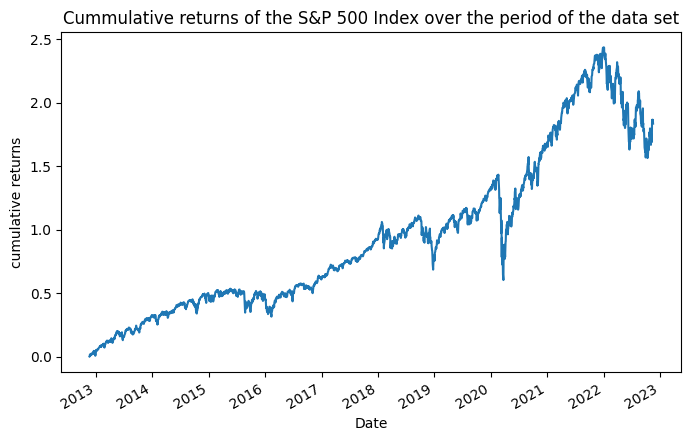

In [65]:
spy_returns = pdr.get_data_yahoo(["SPY"], start, end)["Close"]
spy_returns = spy_returns.pct_change().dropna(axis = 0)
spy_cum = np.cumprod(1 + spy_returns) - 1
spy_cum.columns = ["S&P 500 Index"]

ax = spy_cum.plot(legend=False, figsize=(8,5))
ax.set_ylabel('cumulative returns')
ax.set_title('Cummulative returns of the S&P 500 Index over the period of the data set')

##### 1.3 Data Transformation

To train our alogrithm we split our dataset into three sets. The train and validation set will be used by the algorithm to learn and tune the model. The test set is a seperate set only touched after model implementation to evaluate model performance.

In [66]:
train_set_, test_set = testTrainSplit(df, validation_set = False, w_tt = [0.8, 0.2])
train_set, validation_set = testTrainSplit(train_set_, validation_set = False, w_tt = [0.75, 0.25])

### 2. Distance Metrics

##### 2.1. Derive the empirical correlation matrix

Our algorithm needs a distance matrix as input. To start we will derive the empirical correlation matrix.

In [24]:
stock_tickers  = train_set.columns 
corr0 = pd.DataFrame(getCorrMatrix(train_set), index = stock_tickers, columns = stock_tickers )

As we are utilizing a clustering algorithm a highrachchical cluster map helps us to understand how the stocks are behaving amogst each other.

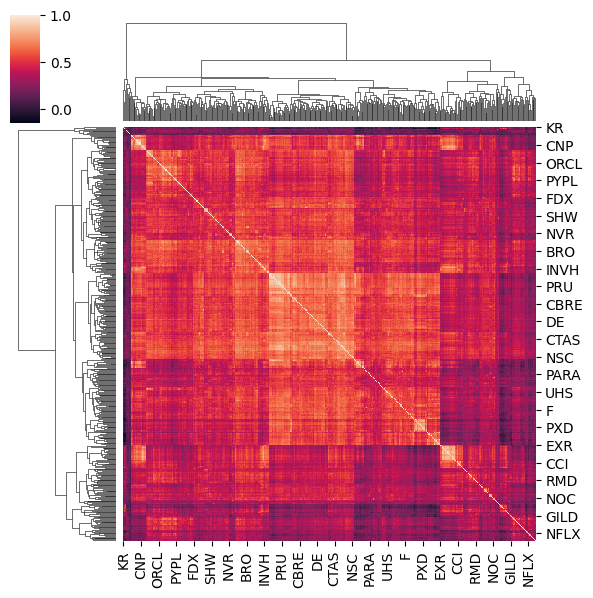

In [20]:
# Create a clustermap
sns.clustermap(corr0, method='average', figsize=(6,6))

##### 2.2 Denoise and Detone the Empirical correlation Matrix

Lets denoise the correlation matrix.

In [25]:
eVal0, eVec0, eVal1, eVec1, corr1, var0 = denoiseMatrix(corr0)
corr1 = pd.DataFrame(corr1, index = stock_tickers, columns = stock_tickers)

A plot to show the effect of the denoising of the eigen-function of our correlation matrix.

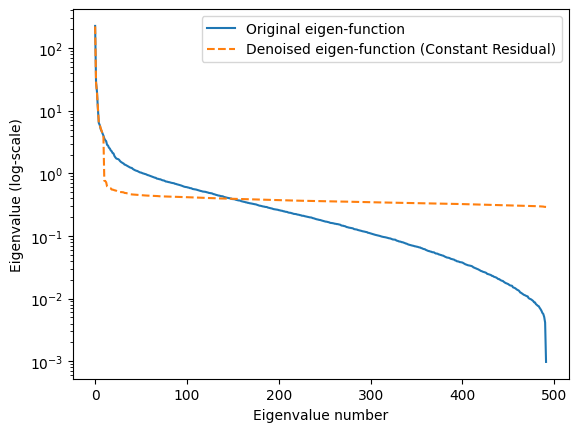

In [40]:
plotEvalDiff(eVal0, eVal1)

Next lets detone the correlation matrix. In essence we are removing the market common component out of all the stocks comovements.

In [28]:
corr2 = detoneMatrix(corr1, eVal1, eVec1)
corr2 = pd.DataFrame(corr2, index = stock_tickers, columns = stock_tickers)

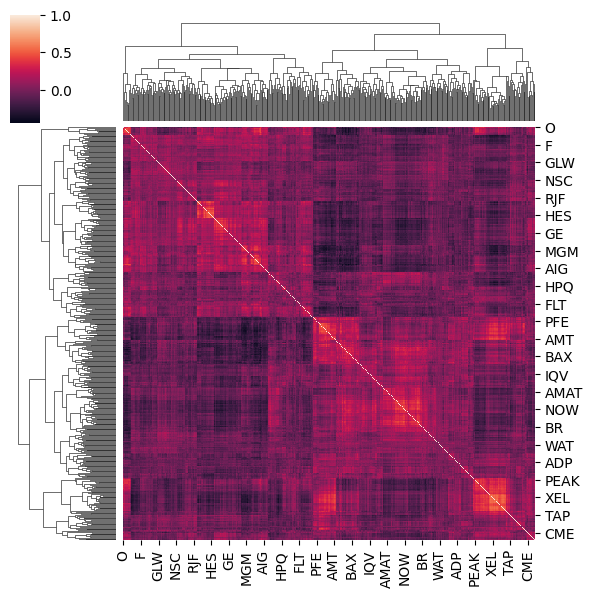

In [30]:
# Create a clustermap
sns.clustermap(corr2, method='average', figsize=(6,6))

##### 2.3. Minkowski distance

We will use the mikowski distance metric. Our denoised and detoned correlation matrix is transformed accordingly.

In [76]:
min_matrix0 = np.array(pairwise_distances(corr2, metric = "minkowski", p = 2))

### 3. Algorithm

In this section we quickly present the underlying algorithm that we developed frot the purpose of this project.

##### 3.1. Find optimal nuber of clusters in the dataset

The algorithm will use three methodologies to determine the optimal amount of clusters to be utilized by the clustering algorithm. The elbow method,silhouettes score and the davies boulding index. Below we exemplary present there results of one of the three methods for our base input matrix. The optimal number of clusters sits at the elbow/knee of the function. In our case the optimal number of clusters is 4.

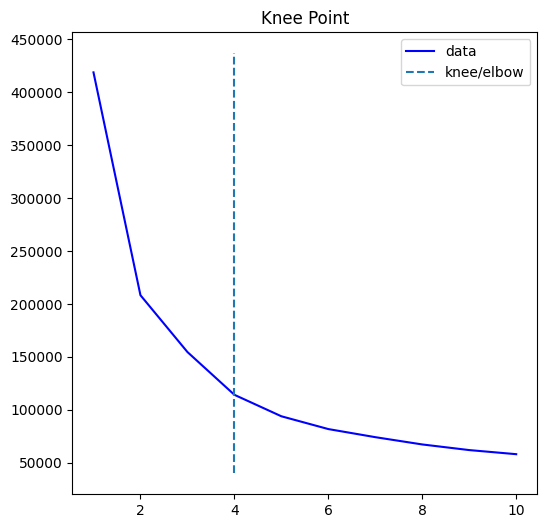

In [74]:
nr_clusters_sse = sse(min_matrix0)

##### 3.2. Running the clustering algorithm

Now that we have the optimal number of clusters we can run our algorithm. The algorithm utlizes the omega score. As threshold we will use the mean annualized return of the underlying index over the last 10 years. This will give us a solid benchmark. For a detailed description of the algorithms structure refer to the thesis report. The output is an array of the optimal portfolio allocation.

In [77]:
w = optPort_nco(train_set, min_matrix0, 4, 0.074, 50, 5)

In [80]:
#The firt 3 weights
w[0:3]

array([0.0003972 , 0.00608672, 0.00015243])

##### 3.3 Distance metric tuning

In this section we want to evaluate whether special p-paramteters have a significant effect on model performance. Thus, we will implement the model of over different time periods with different different p parameters between 1 and 2. First lets define our time periods and possible p values.

In [4]:
p_values = [1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]

set1_, set2_ = testTrainSplit(df, False, w_tt = [0.5,0.5])
period1, period2, period3 = testTrainSplit(set1_, True, w_tvt = [0.33,0.33,0.34]) 
period4, period5, period6 = testTrainSplit(set2_, True, w_tvt = [0.33,0.33,0.34])
periods = [period1, period2, period3, period4, period5, period6]

Now lets implement a portfolio for each p parameter.

In [68]:
combined_min_ports = []
period_nr = 1

for period in periods:

    train, test = testTrainSplit(period, validation_set = False, w_tt = [0.8,0.2])
    corr_min = denoise_and_detone(train)
    min_ports = []

    for p in tqdm(p_values):
        min_matrix_ = np.array(pairwise_distances(corr_min, metric = "minkowski", p = p))
        nr_clusters_sse = sse(min_matrix_, graph = False)
        w_ = optPort_nco(train, min_matrix_, nr_clusters_sse, 0.074, 1000, 5)
        name = f"P = {p}; Per = {period_nr}"
        port = Portfolio(name, test, w_)
        min_ports.append(port)
    
    period_nr += 1
    
    combined_min_ports.append(min_ports)

100%|██████████| 11/11 [03:08<00:00, 17.10s/it]


In [69]:
p_reports = pd.DataFrame(0, index = [0], columns = ["ARet", "AVol", "Alpha", "p Alpha", "Beta","Sharpe", "Sortino", "IR", "MDD"])
for p in combined_min_ports:
    bm_min = PortfolioBenchmarking(p)
    rep = bm_min.performance_report(withSPY = False)
    p_reports = pd.concat([p_reports, rep])

p_reports = p_reports.drop(0, axis = 0)
p_values_new = p_values*6

In [70]:
r2s = {}
betas_p = {}
betas = {}

for m in p_reports.columns:
    
    r2 = round(regression(p_values_new, p_reports.loc[:,m].values)[4],4)
    pvalue_beta = round(regression(p_values_new, p_reports.loc[:,m].values)[3],4)
    beta = round(regression(p_values_new, p_reports.loc[:,m].values)[2],4)
    r2s[m] = r2
    betas_p[m] = pvalue_beta
    betas[m] = beta

In [71]:
r2s = pd.DataFrame(r2s, index = ["r2"]).transpose()
betas = pd.DataFrame(betas, index = ["beta"]).transpose()
betas_p = pd.DataFrame(betas_p, index = ["p-value beta"]).transpose()
significance = pd.merge(r2s,betas,how = "outer", left_index = True, right_index = True)
significance = pd.merge(significance,betas_p,how = "outer", left_index = True, right_index = True)

In [72]:
significance

,r2,beta,p-value beta
ARet,0.0000,-0.0055,0.9734
AVol,0.0000,-0.0009,0.9875
Alpha,0.0000,-0.0000,0.9813
p Alpha,0.0027,0.0349,0.6794
Beta,0.0000,-0.0014,0.9793
Sharpe,0.0002,0.0438,0.9202
Sortino,0.0005,0.1474,0.8518
IR,0.0000,-0.0061,0.9895
MDD,0.0000,-0.0000,0.9979


### 4. Perfromance evaluation

#### 4.1. Benchmarking

We will compare our clustering portfolio with a few other common portfolio types, the mean-variance optimized (MVP), risk-parity (RPP), and equal-weighted portfolio (EWP), as well as the S&P index itself (SPY).

First let calculated the portfolio weights for our NCO algorithm. We will train our model on the train set and create a seperate validation set to tune the distance parameter p:

In [76]:
corr_train = denoise_and_detone(train_set)
corr_val = denoise_and_detone(validation_set)

Lets find the p parameter the yielded the highest sharpe ratio over the validation set and create to corresponding distance matrix.

In [79]:
opt_p = p_tuner(train_set, validation_set, corr_train, iter = 1000)

100%|██████████| 11/11 [23:37<00:00, 128.85s/it]


In [80]:
min_matrix1 = np.array(pairwise_distances(corr_val, metric = "minkowski", p = opt_p))

lets finally calculate the final weight allocation over the validation set

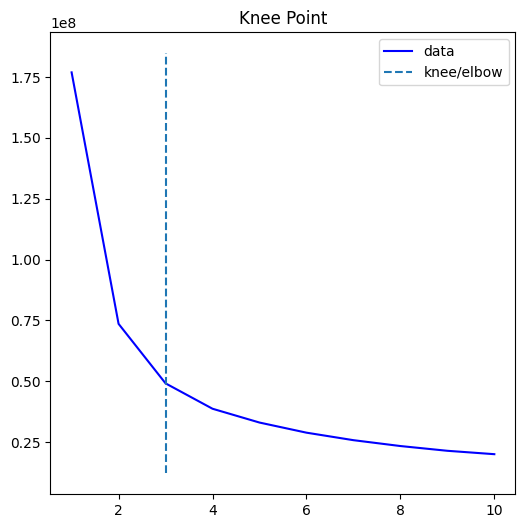

In [82]:
#Optimal number of clusters
nr_clusters_ = sse(min_matrix1)
#Clustering
w_NCO, cluster_NCO = optPort_nco(validation_set, min_matrix1, nr_clusters_, 0.074, 5000, 5, ret_clust = True)

Lets calculate the allocations for some other benchmark portflios.

In [83]:
#EW
w_EW = np.ones(len(train_set_.columns))
w_EW /= [len(train_set_.columns)]*len(train_set_.columns)
#MVO
w_MVO = optPortMVO(train_set_)
#RPP
w_RPP = optPortRPP(train_set_)

Not lets build the portfolios over the test set:

In [84]:
#building the single portfolios
port_NCO = Portfolio(f"NCO p = {opt_p}", test_set, w_NCO)
port_EWP = Portfolio("EWP", test_set, w_EW)
port_MVO = Portfolio("MVO", test_set, w_MVO)
port_RPP = Portfolio("RPP", test_set, w_RPP)
#comparing the portfolios
BM1 = PortfolioBenchmarking([port_NCO, port_EWP, port_MVO, port_RPP])

We are ready to perform some comparisons:

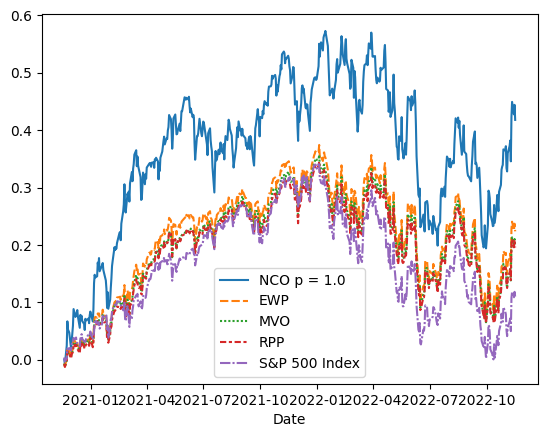

In [85]:
BM1.plot_performance()

In [86]:
BM1.performance_report()

/Users/dario/Desktop/Projects/thesis/algorithm/portfolio_and_backtesting.py:116: RuntimeWarning: invalid value encountered in double_scalars
  information_ratio = (return_difference.mean() * 252) / (volatility * np.sqrt(252))
/Users/dario/Desktop/Projects/thesis/algorithm/thesis_venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


,ARet,AVol,Alpha,p Alpha,Beta,Sharpe,Sortino,IR,MDD
SPY,0.0706,0.1909,0.0000,0.9617,1.0000,0.3698,0.5245,NaN,-0.0753
NCO p = 1.0,0.2074,0.2546,0.0005,0.1826,1.0981,0.8149,1.3289,0.9824,-0.0932
EWP,0.1186,0.1864,0.0002,0.1383,0.9319,0.6363,0.9428,0.9484,-0.0714
MVO,0.1072,0.1821,0.0002,0.1706,0.9182,0.5883,0.8569,0.8260,-0.0707
RPP,0.1056,0.1785,0.0002,0.1864,0.8961,0.5913,0.8643,0.7520,-0.0695


In [88]:
BM1.cum_returns.corr()

,NCO p = 1.0,EWP,MVO,RPP,S&P 500 Index
NCO p = 1.0,1.000000,0.955480,0.940494,0.942174,0.838105
EWP,0.955480,1.000000,0.998584,0.999028,0.936326
MVO,0.940494,0.998584,1.000000,0.999547,0.946990
RPP,0.942174,0.999028,0.999547,1.000000,0.944819
S&P 500 Index,0.838105,0.936326,0.946990,0.944819,1.000000


##### 4.2. Robustness Analysis

##### 4.2.1 Time dimensioning

Let discover the effect of different train-test split layouts on the model performance. The are 2 parateter that we will explore. The ratio of train and test split and the overall sample size.

1. Experiment: Lets create an investments in 5 different investement period an discover whether our results hold up.

In [89]:
#lets create the corresponding investment train and test set_yscale
set1_, set2_ = testTrainSplit(df, False, w_tt = [0.5,0.5])
period1, period2, period3 = testTrainSplit(set1_, True, w_tvt = [0.33,0.33,0.34]) 
period4, period5, period6 = testTrainSplit(set2_, True, w_tvt = [0.33,0.33,0.34])
periods = [period1, period2, period3, period4, period5, period6]

low lets implement our model for all periods and compare

In [90]:
per = 1

reports = {}

for p in periods:

    #generate train val test split
    train_set0, val_set0, test_set0 = testTrainSplit(p, True , w_tvt = [0.6,0.2,0.2])

    #set threshold for omega score
    aret_mkt = 0.074

    #build correlations matricies
    corr_train = denoise_and_detone(train_set0)
    corr_val = denoise_and_detone(val_set0)

    #retriev optimal p parameter
    p_opt_ = p_tuner(train_set0, val_set0, corr = corr_train, th = aret_mkt, iter = 500)

    #implement tuned distance matrix
    min_matrix2 = np.array(pairwise_distances(corr_val, metric = "minkowski", p = p_opt_))

    #get optimal number of clusteres
    nr_clusters_ = sse(min_matrix2, graph = False)

    #calculate optimal portfolio allocation
    w_NCO_, cluster_NCO_ = optPort_nco(val_set0, min_matrix2, nr_clusters_, aret_mkt, 5000, 5, ret_clust = True)    

    #build portfolio
    port_NCO_ = Portfolio(f"NCO Period {per}", test_set0, w_NCO_)

    #generate performance report
    name, pr = port_NCO_.performance_report(True)

    #calculate SPY portfolio as benchmark
    start  = test_set0.index[0] - timedelta(days = 1)
    end  = test_set0.index[len(test_set0.index)-1]
    mkt_returns_ = pdr.get_data_yahoo(["SPY"], start, end)["Close"]
    mkt_returns_ = mkt_returns_.pct_change().dropna(axis = 0)
    mkt = Portfolio_Ret(f"SPY Period {per}", mkt_returns_.loc[:,"SPY"])
    mkt_n, mkt_pr = mkt.performance_report(True)

    #append performances of NCO and SPY to the dataframe
    reports[name] = pr
    reports[mkt_n] = mkt_pr

    #next period
    per += 1

reports = pd.DataFrame(reports, index = ["ARet", "AVol", "Alpha", "p Alpha", "Beta","Sharpe", "Sortino", "IR", "MDD"])

100%|██████████| 11/11 [00:56<00:00,  5.12s/it]
/Users/dario/Desktop/Projects/thesis/algorithm/portfolio_and_backtesting.py:116: RuntimeWarning: invalid value encountered in double_scalars
  information_ratio = (return_difference.mean() * 252) / (volatility * np.sqrt(252))
100%|██████████| 11/11 [00:42<00:00,  3.82s/it]
/Users/dario/Desktop/Projects/thesis/algorithm/portfolio_and_backtesting.py:116: RuntimeWarning: invalid value encountered in double_scalars
  information_ratio = (return_difference.mean() * 252) / (volatility * np.sqrt(252))
100%|██████████| 11/11 [00:39<00:00,  3.58s/it]
/Users/dario/Desktop/Projects/thesis/algorithm/portfolio_and_backtesting.py:116: RuntimeWarning: invalid value encountered in double_scalars
  information_ratio = (return_difference.mean() * 252) / (volatility * np.sqrt(252))
100%|██████████| 11/11 [00:39<00:00,  3.59s/it]
/Users/dario/Desktop/Projects/thesis/algorithm/portfolio_and_backtesting.py:116: RuntimeWarning: invalid value encountered in doub

In [91]:
reports.transpose()

,ARet,AVol,Alpha,p Alpha,Beta,Sharpe,Sortino,IR,MDD
NCO Period 1,0.1800,0.1102,-0.0002,0.4694,1.1511,1.6336,2.1274,-0.5019,-0.0381
SPY Period 1,0.1847,0.0906,-0.0000,0.0797,1.0000,2.0373,2.5936,NaN,-0.0318
NCO Period 2,-0.0539,0.2570,0.0004,0.6719,1.1901,-0.2096,-0.3731,0.5443,-0.0633
SPY Period 2,-0.1269,0.1865,-0.0000,0.3665,1.0000,-0.6806,-1.0973,NaN,-0.0444
NCO Period 3,0.2500,0.0899,0.0002,0.5845,1.2604,2.7808,3.4367,1.8065,-0.0318
SPY Period 3,0.1642,0.0619,0.0000,0.0458,1.0000,2.6526,2.8387,NaN,-0.0255
NCO Period 4,0.1768,0.1618,-0.0003,0.4902,1.3052,1.0930,1.4377,-0.2477,-0.0570
SPY Period 4,0.1946,0.1142,-0.0000,0.0000,1.0000,1.7034,2.0934,NaN,-0.0370
NCO Period 5,1.1523,0.3075,0.0027,0.1403,1.1514,3.7467,10.2124,2.8993,-0.1373
SPY Period 5,0.4116,0.1500,0.0000,0.0000,1.0000,2.7437,4.0880,NaN,-0.0468


Experiment 2: Train Test Ratios

In [92]:
ratios = [[0.1,0.9],[0.25,0.75],[0.4,0.6],[0.5,0.5],[0.6,0.4],[0.75,0.25],[0.9,0.1]]

In [94]:
reports2 = {}

for r in ratios:

    #split weights
    w_tvt0 = [(r[0]/4)*3,(r[0]/4),r[1]]

    #build the train val test sets
    train_set1, val_set1, test_set1 = testTrainSplit(df, True , w_tvt = w_tvt0)

    #set omega threshold
    th = 0.074

    #build correlation matricies
    corr_train = denoise_and_detone(train_set1)
    corr_val = denoise_and_detone(val_set1)

    #calculate optimal p parameter
    p_opt0 = p_tuner(train_set1, val_set1, corr_train, th = th, iter = 500)

    #set tuned distance matrix
    min_matrix3 = np.array(pairwise_distances(corr_val, metric = "minkowski", p = p_opt0))

    #optimal number of clusters
    nr_clusters_ = sse(min_matrix3, graph = False)
    
    #portfolio allocation
    w_NCO_, cluster_NCO_ = optPort_nco(val_set1, min_matrix3, nr_clusters_, th, 5000, 5, ret_clust = True)    

    #building portfolio
    port_NCO_ = Portfolio(f"NCO Split {r}", test_set1, w_NCO_)

    #create performance report
    name, pr = port_NCO_.performance_report(True)

    #create SPY benchmark portfolio
    start  = test_set1.index[0] - timedelta(days = 1)
    end  = test_set1.index[len(test_set1.index)-1]
    mkt_returns_ = pdr.get_data_yahoo(["SPY"], start, end)["Close"]
    mkt_returns_ = mkt_returns_.pct_change().dropna(axis = 0)
    mkt = Portfolio_Ret(f"SPY Split {r}", mkt_returns_.loc[:,"SPY"])
    mkt_n, mkt_pr = mkt.performance_report(True)

    #appaned reports to dataframe
    reports2[name] = pr
    reports2[mkt_n] = mkt_pr

reports2 = pd.DataFrame(reports2, index = ["ARet", "AVol", "Alpha", "p Alpha", "Beta","Sharpe", "Sortino", "IR", "MDD"])    

100%|██████████| 11/11 [01:46<00:00,  9.70s/it]
/Users/dario/Desktop/Projects/thesis/algorithm/portfolio_and_backtesting.py:116: RuntimeWarning: invalid value encountered in double_scalars
  information_ratio = (return_difference.mean() * 252) / (volatility * np.sqrt(252))
100%|██████████| 11/11 [03:05<00:00, 16.88s/it]
/Users/dario/Desktop/Projects/thesis/algorithm/portfolio_and_backtesting.py:116: RuntimeWarning: invalid value encountered in double_scalars
  information_ratio = (return_difference.mean() * 252) / (volatility * np.sqrt(252))
100%|██████████| 11/11 [06:45<00:00, 36.90s/it]
/Users/dario/Desktop/Projects/thesis/algorithm/portfolio_and_backtesting.py:116: RuntimeWarning: invalid value encountered in double_scalars
  information_ratio = (return_difference.mean() * 252) / (volatility * np.sqrt(252))
100%|██████████| 11/11 [08:39<00:00, 47.21s/it]
/Users/dario/Desktop/Projects/thesis/algorithm/portfolio_and_backtesting.py:116: RuntimeWarning: invalid value encountered in doub

In [95]:
reports2.transpose()

,ARet,AVol,Alpha,p Alpha,Beta,Sharpe,Sortino,IR,MDD
"NCO Split [0.1, 0.9]",0.1648,0.2129,0.0002,0.0284,1.1333,0.7743,0.9475,0.8890,-0.2276
"SPY Split [0.1, 0.9]",0.1041,0.1791,0.0000,0.0000,1.0000,0.5810,0.6917,NaN,-0.1949
"NCO Split [0.25, 0.75]",0.1504,0.2673,0.0001,0.5676,1.2040,0.5626,0.7201,0.3437,-0.2483
"SPY Split [0.25, 0.75]",0.1007,0.1895,-0.0000,0.0000,1.0000,0.5315,0.6301,NaN,-0.1949
"NCO Split [0.4, 0.6]",0.1541,0.2570,0.0001,0.7383,1.1597,0.5995,0.7429,0.2901,-0.2344
"SPY Split [0.4, 0.6]",0.1192,0.1977,0.0000,0.1480,1.0000,0.6027,0.7016,NaN,-0.1949
"NCO Split [0.5, 0.5]",0.1291,0.2956,0.0000,0.9960,1.1902,0.4367,0.5723,0.1351,-0.2634
"SPY Split [0.5, 0.5]",0.1082,0.2143,-0.0000,0.5097,1.0000,0.5048,0.6029,NaN,-0.1949
"NCO Split [0.6, 0.4]",0.2049,0.2695,0.0003,0.0335,1.1356,0.7604,0.9687,1.1939,-0.2091
"SPY Split [0.6, 0.4]",0.1228,0.2284,0.0000,0.0025,1.0000,0.5375,0.6478,NaN,-0.1949


##### 4.2.2 Rebalacing

Let discover the effect of rebalacing on the porfolio performance.

In [96]:
#set investment start
investment_start = test_set.index[0]
investment_start

Timestamp('2020-11-18 00:00:00')

In [98]:
# potfolio with rebalacing
ret_RB, clusters_RB = optPort_nco_RB(df, investment_start, 5000, ret_clust = True, tuneIter = 500)

100%|██████████| 11/11 [01:16<00:00,  7.00s/it]


In [99]:
port_NCOMO_RB = Portfolio_Ret("NCO Monthly Rebalanced", ret_RB.iloc[:len(ret_RB)-1])

In [100]:
bm4 = PortfolioBenchmarking([port_NCOMO_RB, port_NCO])

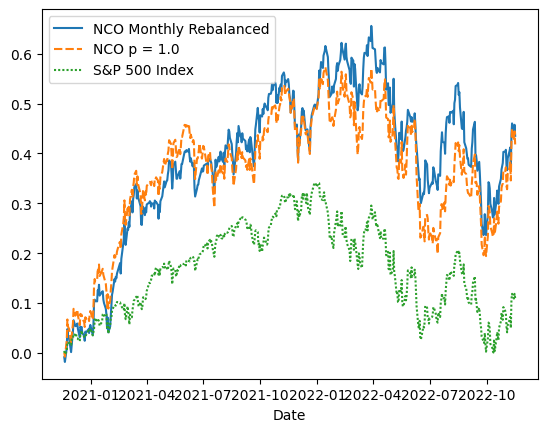

In [101]:
bm4.plot_performance()

In [102]:
bm4.performance_report()

/Users/dario/Desktop/Projects/thesis/algorithm/portfolio_and_backtesting.py:116: RuntimeWarning: invalid value encountered in double_scalars
  information_ratio = (return_difference.mean() * 252) / (volatility * np.sqrt(252))
/Users/dario/Desktop/Projects/thesis/algorithm/thesis_venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


,ARet,AVol,Alpha,p Alpha,Beta,Sharpe,Sortino,IR,MDD
SPY,0.0706,0.1909,0.0000,0.9617,1.0000,0.3698,0.5245,NaN,-0.0753
NCO Monthly Rebalanced,0.2109,0.2442,0.0006,0.1633,1.0235,0.8638,1.4159,1.0003,-0.0897
NCO p = 1.0,0.2074,0.2546,0.0005,0.1826,1.0981,0.8149,1.3289,0.9824,-0.0932


##### 4.2.3 Application in a different market environment

For compareable data we will use the components of the Jakarta Composite Index. We will perform the same steps as in our base alogrithm for the S&P500

In [103]:
#load the data 
df_tyo = pd.read_csv("data/nikkei225comps.csv")
df_tyo = df_tyo.set_index("Date").pct_change().iloc[1:]
df_tyo.index = pd.to_datetime(df_tyo.index)

In [104]:
#create train test splits and derive the denoised and detoned correlation matrix
train_set_tyo_, test_set_tyo = testTrainSplit(df_tyo, validation_set = False, w_tt = [0.8, 0.2])
train_set_tyo, val_set_tyo = testTrainSplit(train_set_tyo_, validation_set = False, w_tt = [0.5, 0.5])
corr2_tyo = denoise_and_detone(train_set_tyo)

In [105]:
#optimal p parameter
pv_tyo = p_tuner(train_set_tyo, val_set_tyo, corr2_tyo, iter = 1000)

100%|██████████| 11/11 [08:04<00:00, 44.06s/it]


In [106]:
#derive the tuned distance matrix
corr2_tyo_val = denoise_and_detone(val_set_tyo)
min_matrix_tyo = np.array(pairwise_distances(corr2_tyo_val, metric = "minkowski", p = pv_tyo))

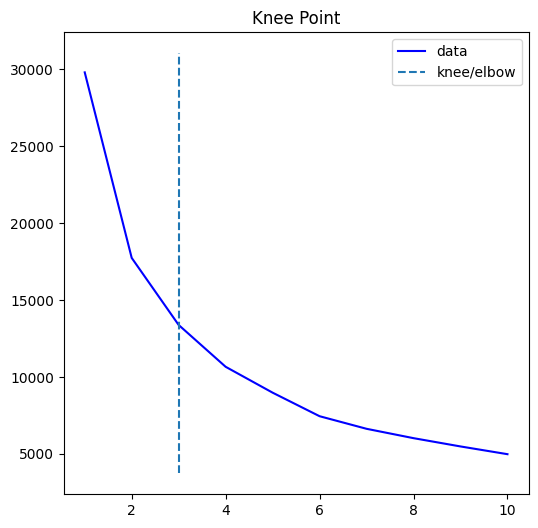

In [107]:
#Optimal number of clusters
nr_clusters_tyo = sse(min_matrix_tyo)
#Clustering
w_NCO_tyo, cluster_NCO_tyo = optPort_nco(val_set_tyo, min_matrix_tyo, nr_clusters_tyo, 0.074, 5000, 5, ret_clust = True)

In [108]:
# Jakarta Composite Index
nikkei225_ret = pdr.get_data_yahoo(["^N225"], test_set_tyo.index[0], end)["Close"].pct_change()[1:len(test_set_tyo)]
nikkei225_ret = pd.Series(nikkei225_ret.values.reshape(-1), index = nikkei225_ret.index)
nikkei225_port = Portfolio_Ret("Nikkei225 Index", nikkei225_ret)

In [109]:
#EW
w_EW_tyo = np.ones(len(train_set_tyo_.columns))
w_EW_tyo /= [len(train_set_tyo_.columns)]*len(train_set_tyo_.columns)
#MVO
w_MVO_tyo = optPortMVO(train_set_tyo_)
#RPP
w_RPP_tyo = optPortRPP(train_set_tyo_)

In [110]:
#building the single portfolios
port_NCO_tyo = Portfolio(f"NCO Nikkei225 p = {pv_tyo}", test_set_tyo.iloc[1:], w_NCO_tyo)
port_EWP_tyo = Portfolio("EWP Nikkei225", test_set_tyo.iloc[1:], w_EW_tyo)
port_MVO_tyo = Portfolio("MVO Nikkei225", test_set_tyo.iloc[1:], w_MVO_tyo)
port_RPP_tyo = Portfolio("RPP Nikkei225", test_set_tyo.iloc[1:], w_RPP_tyo)
#comparing the portfolios
BM5 = PortfolioBenchmarking([port_NCO_tyo, port_EWP_tyo, port_MVO_tyo, port_RPP_tyo, nikkei225_port])

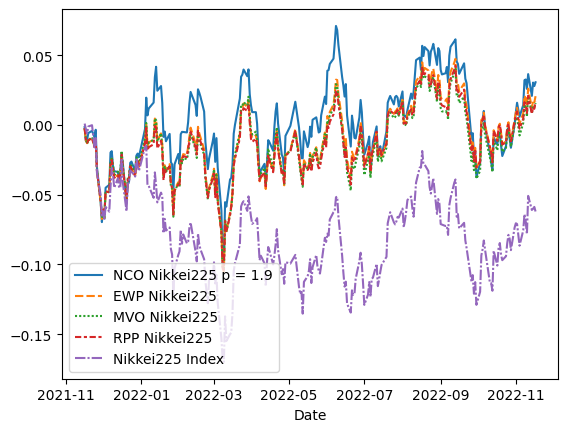

In [111]:
BM5.plot_performance(False)

In [112]:
BM5.performance_report(withSPY = False, bm = "^N225")

/Users/dario/Desktop/Projects/thesis/algorithm/portfolio_and_backtesting.py:116: RuntimeWarning: invalid value encountered in double_scalars
  information_ratio = (return_difference.mean() * 252) / (volatility * np.sqrt(252))


,ARet,AVol,Alpha,p Alpha,Beta,Sharpe,Sortino,IR,MDD
NCO Nikkei225 p = 1.9,0.0522,0.2060,0.0004,0.4151,0.8423,0.2535,0.3989,0.8549,-0.0846
EWP Nikkei225,0.0369,0.1782,0.0003,0.3265,0.7829,0.2069,0.3416,0.9557,-0.0704
MVO Nikkei225,0.0323,0.1797,0.0003,0.3061,0.8037,0.1795,0.3014,0.9931,-0.0705
RPP Nikkei225,0.0318,0.1719,0.0003,0.3371,0.7598,0.1849,0.3086,0.9073,-0.0676
Nikkei225 Index,-0.0438,0.2086,-0.0000,0.5127,1.0000,-0.2099,-0.3481,NaN,-0.0694


## 5. Interpretatbility

#### 5.1 Cluster Analysis

##### 5.1.1 Cluster persistatance

We will take a look at the rebalanced portfolio and see whether the components of the clusters that found be the algorithm persist with time.

Experiment 1: Same setting with many initializiations

In [113]:
clusters_NCO = []
for i in tqdm(range(20)):
    mat = pd.DataFrame(min_matrix_)
    nrc = sse(mat, graph = False)
    _, clusters, _ = clusterKMeansBase(mat, nrc)
    clusters_NCO.append(clusters)

100%|██████████| 20/20 [01:07<00:00,  3.38s/it]


In [114]:
pc1 = persistance_counter(clusters_NCO)

<AxesSubplot: >

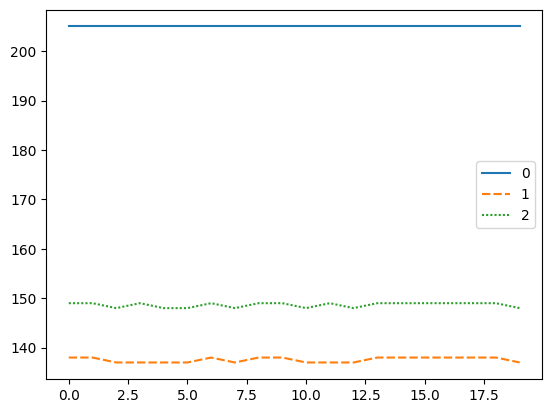

In [115]:
sns.lineplot(pd.DataFrame(pc1))

Experiment2: Over time

In [116]:
pc2 = persistance_counter(clusters_RB)

<AxesSubplot: >

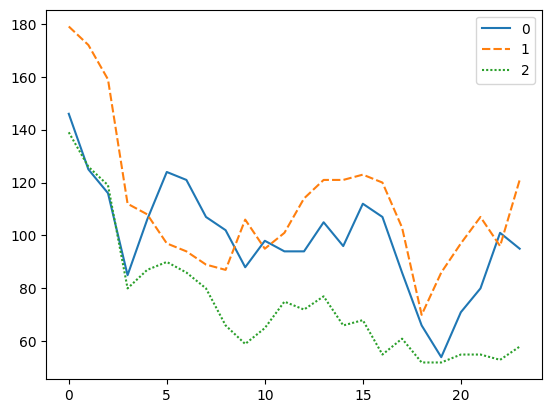

In [117]:
sns.lineplot(pd.DataFrame(pc2))

##### 5.1.2 Cluster Interpretation

In [146]:
def stock_finder(df, clusters):
    stock_finder = {}
    for nr in range(len(df.columns)):
        stock_finder[nr] = df.columns[nr]
    clusters_ticker = {}
    for cl, stocks in clusters.items():
        clusters_ticker[cl] = []
        for stock in stocks:
            clusters_ticker[cl].append(stock_finder[stock])  

    output = pd.DataFrame(0, columns = ["Ticker", "Cluster"], index = range(len(df.columns)))
    ind = 0
    for c, stocks in clusters_ticker.items():
        for s in stocks:
            output.iloc[ind] = [s,c]
            ind += 1 
    return output 

In [147]:
clusters_found = stock_finder(df, cluster_NCO).set_index("Ticker")

In [149]:
funds = pd.read_csv("data/funds.csv")
funds = funds[funds["datadate"] == "12/31/2021"].set_index("tic")

In [150]:
ratios = pd.read_csv("data/ratios.csv")
ratios = ratios[ratios["public_date"] == "12/31/2021"].set_index("TICKER")

In [151]:
clusters_found = clusters_found.merge(funds, how = "inner", left_index = True, right_index = True)
clusters_found = clusters_found.merge(ratios, how = "inner", left_index = True, right_index = True)

In [152]:
clusters_found.fillna(0, inplace = True)
clusters_found.drop("fyear", axis = 1, inplace = True)

In [153]:
from sklearn.preprocessing import LabelEncoder
def encode(line):
    enc = LabelEncoder()
    n = enc.fit_transform(line)
    return n

In [154]:
for i in clusters_found.columns:
    if type(clusters_found.loc[:,i][0]) == "str":
        clusters_found.loc[:,i] = encode(clusters_found.loc[:,i])
    else:
        pass
    
    if clusters_found.loc[:,i].dtype == "object":
        clusters_found.drop(i, axis = 1, inplace = True)

In [160]:
betas = {}
betas_p = {}
r2s = {}
y = clusters_found.drop("Cluster", axis = 1)
X = pd.DataFrame(clusters_found["Cluster"].values, columns = ["X"])

In [161]:
for s in y.columns:
    c = pd.DataFrame(y.loc[:,s].values, columns = ["y"])
    z = X
    r2 = round(regression(c, z)[4],4)
    pvalue_beta = round(regression(c, z)[3],4)
    beta = round(regression(c, z)[2],4)
    r2s[s] = r2
    betas_p[s] = pvalue_beta
    betas[s] = beta

In [164]:
betas_p = pd.DataFrame(betas_p, index = ["p-values"]).transpose()
betas = pd.DataFrame(betas, index = ["p-values"]).transpose()
r2s = pd.DataFrame(r2s, index = ["p-values"]).transpose()

In [167]:
significance_report = pd.merge(betas, betas_p, how = "inner", left_index = True, right_index = True)
significance_report = pd.merge(significance_report, r2s, how = "inner", left_index = True, right_index = True)
significance_report.columns = ["beta", "p_value beta", "r2"]

In [168]:
significance_report

,beta,p_value beta,r2
gvkey,-0.0000,0.0002,0.0367
arc,0.0000,0.8097,0.0002
at,-0.0000,0.3460,0.0023
bkvlps,0.0001,0.8731,0.0001
ch,-0.0000,0.4248,0.0017
...,...,...,...
adv_sale,-2.6622,0.0520,0.0100
staff_sale,-0.1937,0.4452,0.0015
accrual,-0.3535,0.6273,0.0006
ptb,-0.0080,0.0062,0.0197
